In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15QxD-ZNrVypq9sDP4GC6vShlfdeDjMpL' -O book.txt

--2022-10-22 14:42:51--  https://docs.google.com/uc?export=download&id=15QxD-ZNrVypq9sDP4GC6vShlfdeDjMpL
Resolving docs.google.com (docs.google.com)... 142.250.1.113, 142.250.1.138, 142.250.1.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.1.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ji1krsc90ln0c9e2q6ln2ih7ai93vs39/1666449750000/15660547828700774342/*/15QxD-ZNrVypq9sDP4GC6vShlfdeDjMpL?e=download&uuid=1e105c3f-8315-4897-9133-5971befe6a24 [following]
--2022-10-22 14:42:52--  https://doc-10-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ji1krsc90ln0c9e2q6ln2ih7ai93vs39/1666449750000/15660547828700774342/*/15QxD-ZNrVypq9sDP4GC6vShlfdeDjMpL?e=download&uuid=1e105c3f-8315-4897-9133-5971befe6a24
Resolving doc-10-58-docs.googleusercontent.com (doc-10-58-docs.googleusercontent.com)... 74.125.202.132, 2607:f8b0:4001

In [ ]:
!pip install -qq keras_nlp transformers

     |████████████████████████████████| 142 kB 4.1 MB/s 
     |████████████████████████████████| 5.3 MB 37.0 MB/s 
     |████████████████████████████████| 5.9 MB 46.3 MB/s 
     |████████████████████████████████| 163 kB 33.1 MB/s 
     |████████████████████████████████| 7.6 MB 49.4 MB/s 
     |████████████████████████████████| 578.0 MB 12 kB/s 
     |████████████████████████████████| 4.6 MB 42.3 MB/s 


In [ ]:
import numpy as np
import re
import string
import tensorflow as tf

In [ ]:
def preprocessor(text):  # не обязательный шаг, в Tokenizer встроено большинство фильтров (так проще только в данной задаче, чтобы не включать в строчки текста ненужные токены)
    chars = re.escape(string.punctuation)
    text = re.sub(r'['+chars+']', '', text)
    text = re.sub('\’', '', text)
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
    return text.strip()

In [ ]:
text = open("book.txt").read().replace("\n", "").lower()
text = preprocessor(text)
text[:250]

'the boy who lived mr and mrs dursley of number four privet drive were proud to say that they were perfectly normal thank you very much they were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold'

**Simple Baseline**

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts([text])

In [ ]:
tokenizer.word_index["mysterious"]

1363

In [ ]:
seq_len = 11
text_list = text.split() 

sequences = []
for i in range(0, len(text_list) - seq_len, seq_len):
    sequences.append(" ".join(text_list[i:i+seq_len]))

In [ ]:
input_sequences = []
for line in sequences:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

In [ ]:
input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=seq_len, padding='pre'))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
inputs, targets = input_sequences[:, :-1], input_sequences[:, -1]

targets = tf.keras.utils.to_categorical(targets, num_classes=vocab_size)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),  # True if 2 LSTMs
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(vocab_size//2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         812416    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6347)              818763    
                                                                 
Total params: 1,729,995
Trainable params: 1,729,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ]

In [ ]:
history = model.fit(inputs, targets, epochs=100, validation_split=0.2, callbacks=callbacks, verbose=1)

Epoch 1/100
1810/1810 [==============================] - 19s 9ms/step - loss: 6.5765 - accuracy: 0.0565 - val_loss: 6.2603 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 2/100
1810/1810 [==============================] - 15s 8ms/step - loss: 6.1311 - accuracy: 0.0933 - val_loss: 6.0368 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 3/100
1810/1810 [==============================] - 15s 8ms/step - loss: 5.8604 - accuracy: 0.1170 - val_loss: 5.8770 - val_accuracy: 0.1162 - lr: 0.0010
Epoch 4/100
1810/1810 [==============================] - 15s 8ms/step - loss: 5.6276 - accuracy: 0.1343 - val_loss: 5.8003 - val_accuracy: 0.1232 - lr: 0.0010
Epoch 5/100
1810/1810 [==============================] - 15s 8ms/step - loss: 5.4430 - accuracy: 0.1452 - val_loss: 5.7265 - val_accuracy: 0.1328 - lr: 0.0010
Epoch 6/100
1810/1810 [==============================] - 15s 8ms/step - loss: 5.2811 - accuracy: 0.1532 - val_loss: 5.7238 - val_accuracy: 0.1342 - lr: 0.0010
Epoch 7/100
1810/1810 [=======================

In [ ]:
# predictions

start_sample = "harry took magic talking hat in his hands"

next_words = 17
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([start_sample])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=seq_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_idx = np.argmax(predicted)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_idx:
            output_word = word
            break
    start_sample += " " + output_word
print(start_sample)

harry took magic talking hat in his hands and a few of the hall and the daily plants and the corridor and the philosophers stone


Снизив размер словаря с 10000 до 5000 соответственно качество немного повыилось. Как и всегда нужно проверять большое число гипотез (если нет твердой интуиции) и выбирать лучший вариант.

**Transformers**

In [ ]:
import keras_nlp

In [ ]:
BATCH_SIZE = 64
SEQ_LEN = 128
MIN_TRAINING_SEQ_LEN = 20  # маленькое значение - скорее всего даст абра-кадабру на предикте, больше не получится из-за маленького сплита текста

EMBED_DIM = 256
FEED_FORWARD_DIM = 256
NUM_HEADS = 3  # количество голов в MHA
NUM_LAYERS = 2  # количество слоев трансформера - декодера
VOCAB_SIZE = 5000

EPOCHS = 5

NUM_TOKENS_TO_GENERATE = 60

In [ ]:
text = open("book.txt").read().lower()
"""
text = text..replace("\n", "").split()
new_text = []
for i in range(0, len(text) - 100, 100):
    new_text.extend(text[i:i+100] + ["\n"])
text = " ".join(new_text)
"""
boundary = int(len(text) * 0.8)
text_train = text[:boundary]
text_valid = text[boundary:]

with open("book_train.txt", "w") as infile:
    infile.write(text_train)

with open("book_valid.txt", "w") as infile:
    infile.write(text_valid)

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    lowercase = tf.strings.regex_replace(lowercase, "<[^>]*>", '') 
    lowercase = tf.strings.regex_replace(lowercase, "[\W]+", ' ')
    lowercase = tf.strings.regex_replace(lowercase, "[^\w]", ' ')
    lowercase = tf.strings.regex_replace(lowercase, "[^a-zA-Z0-9]+", ' ')
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
raw_train_ds = (
    tf.data.TextLineDataset("book_train.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .map(lambda x: custom_standardization(x))
    .batch(1)  # заменить на 1 если создаем словарь
    .shuffle(buffer_size=256)
)

raw_valid_ds = (
    tf.data.TextLineDataset("book_valid.txt")
    .filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    .map(lambda x: custom_standardization(x))
    .batch(1)
    .shuffle(buffer_size=256)
)

In [ ]:
# в оригинальной статье приведен такой метод, но он в настоящее время не реализован в установочном пакете
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    raw_train_ds,
    vocabulary_size=VOCAB_SIZE,
    suffix_indicator="##",
    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
)

AttributeError: ignored

In [ ]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
# создаем word-piece словарь, где различные части слов и популярные обороты заменены на ##
bert_tokenizer_params=dict(lower_case=False)
reserved_tokens=["[PAD]", "[UNK]", "[BOS]"]

bert_vocab_args = dict(
    vocab_size = VOCAB_SIZE,
    reserved_tokens=reserved_tokens,
    bert_tokenizer_params=bert_tokenizer_params,
    suffix_indicator='##',
    learn_params={},
)

In [ ]:
vocab = bert_vocab.bert_vocab_from_dataset(
    raw_train_ds.batch(BATCH_SIZE).prefetch(2),
    **bert_vocab_args
)

In [ ]:
# создаем токенайзер, использующий подслова
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

In [ ]:
# докидываем в последоватеьности [BOS] токен
start_packer = keras_nlp.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)

In [ ]:
# криво, но пересоздаем датасеты
raw_train_ds = (
    tf.data.TextLineDataset("book_train.txt")
    .filter(lambda x: tf.strings.length(x) > 10)
    .map(lambda x: custom_standardization(x))
    .batch(BATCH_SIZE)  
    .shuffle(buffer_size=256)
)

raw_valid_ds = (
    tf.data.TextLineDataset("book_valid.txt")
    .filter(lambda x: tf.strings.length(x) > 10)
    .map(lambda x: custom_standardization(x))
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

In [ ]:
# выделяем фичи и таргеты
def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels

train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = raw_valid_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)

embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(  # к обычному слою эмбеддинга добавляется позиционное кодирование токенов, удобно!
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)

for _ in range(NUM_LAYERS):
    decoder_layer = keras_nlp.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # без cross-attention: откуда ведь брать V и K из энкодера (он не используется)

outputs = tf.keras.layers.Dense(VOCAB_SIZE)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)  # измеряет качество генерации образца вероятностной моделью

model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddin  (None, None, 256)        1312768   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_decoder (Transf  (None, None, 256)        394749    
 ormerDecoder)                                                   
                                                                 
 transformer_decoder_1 (Tran  (None, None, 256)        394749    
 sformerDecoder)                                                 
                                                                 
 dense (Dense)               (None, None, 5000)        128500

In [ ]:
model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=EPOCHS)

Epoch 1/5
123/123 [==============================] - 15s 98ms/step - loss: 0.5790 - perplexity: 532.4481 - val_loss: 0.5284 - val_perplexity: 274.7203
Epoch 2/5
123/123 [==============================] - 10s 81ms/step - loss: 0.4740 - perplexity: 175.8292 - val_loss: 0.4609 - val_perplexity: 132.7377
Epoch 3/5
123/123 [==============================] - 10s 82ms/step - loss: 0.4220 - perplexity: 99.9960 - val_loss: 0.4398 - val_perplexity: 109.7115
Epoch 4/5
123/123 [==============================] - 11s 83ms/step - loss: 0.3922 - perplexity: 72.3802 - val_loss: 0.4346 - val_perplexity: 102.9027
Epoch 5/5
123/123 [==============================] - 11s 82ms/step - loss: 0.3691 - perplexity: 56.3931 - val_loss: 0.4334 - val_perplexity: 101.4454


In [ ]:
prompt_tokens = tf.convert_to_tensor([tokenizer.token_to_id("[BOS]")])

def token_logits_fn(inputs):
    cur_len = inputs.shape[1]
    output = model(inputs)
    return output[:, cur_len - 1, :]  

In [ ]:
# диамически ищет наболее вероятные токены
output_tokens = keras_nlp.utils.top_p_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
    p=0.9,
    from_logits=True,
)
txt = tokenizer.detokenize(output_tokens)
txt = re.sub("\[(?:[^\]|]*\|)?([^\]|]*)\]", '', txt.numpy().decode("utf-8"))
txt = re.sub(' +', ' ', txt).strip()
print(f"Top-P search generated text: \n{txt}\n")

Top-P search generated text: 
said the fear dirking cooked the bed fained him i s at harry finally comond who slipped tutacracker might coline s had bills



**State-of-the-art**

In [ ]:
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel  
# или TFGPT2Model как feature extractor для получения last_hidden_state и его использования с др. головой

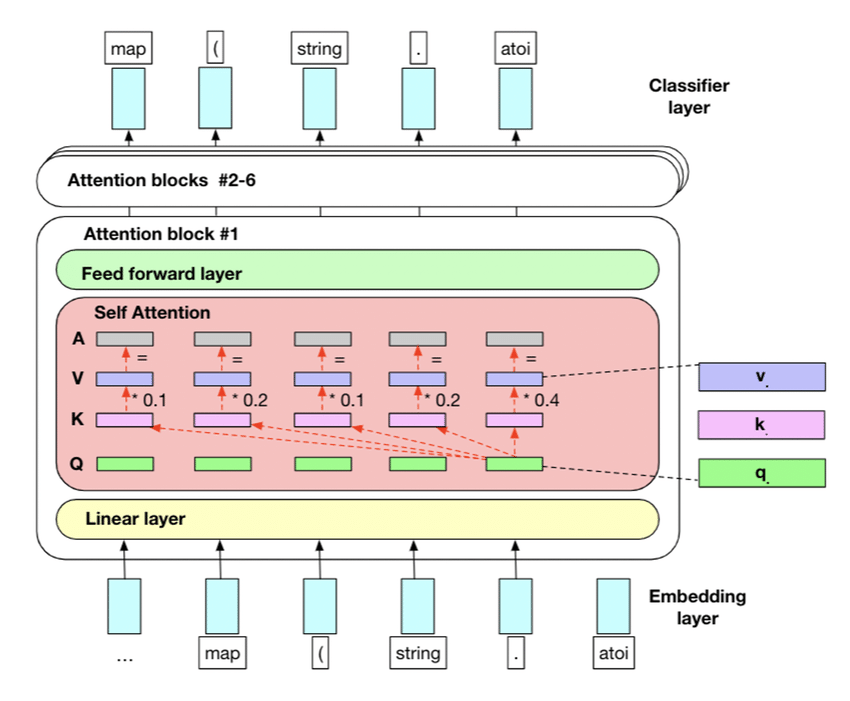

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
model = TFGPT2LMHeadModel.from_pretrained("gpt2-large", pad_token_id=tokenizer.eos_token_id)

text = "harry took magic talking hat and put it right on the top of the school roof"
input_ids = tokenizer.encode(text, return_tensors='tf')

# top-k & top-p search
top_kp_output = model.generate(input_ids, 
                               max_length=100,
                               top_k=50, 
                               top_p=0.85, 
                               num_return_sequences=5,
                               do_sample=True
)

In [ ]:
print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(top_kp_output):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
    print('')

Output:
----------------------------------------------------------------------------------------------------
0: harry took magic talking hat and put it right on the top of the school roof and went to talk with some magic talking hat.

"This is the best one, Harry, he's very smart, I think he can be a great wizard!"

Harry was stunned by his friend's praise, he never thought about his friends opinions before.

"That was really nice Harry. I think I could use a wizard, like Dumbledore."

Harry felt embarrassed as his friend...

1: harry took magic talking hat and put it right on the top of the school roof.

Then he opened the window and jumped off the roof.

"Hurry up!" said Harry.

But when Harry opened the window, the wind had already started whipping his hair and making him feel like he was a little bit cold.

"Let me go!" he yelled.

"No, Harry!" said the man who was running in the middle of the road....

2: harry took magic talking hat and put it right on the top of the school roof 

In [ ]:
# или так (похоже модель также училась на этих книжках, знает имена героев, не поименованных в запросе)
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2-large')
set_seed(42)
generator(text, max_length=100, num_return_sequences=3)

Downloading:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "harry took magic talking hat and put it right on the top of the school roof, a place he already knew would be open to everyone! He quickly used his powers to create a magical ring by turning the school in the middle of the night! It was a pretty neat trick, it took a bit of time to activate but by the end of the day it was so much fun, the whole school was in an uproar because the whole school was gone but that didn't matter because that was only"},
 {'generated_text': 'harry took magic talking hat and put it right on the top of the school roof and went down to the roof and told the children and teachers there there what he had heard about that day."\n\nBut if Harry did not lie to the adults in charge of the Quidditch World Cup, the result is that he had to tell them a falsehood. At the very least, there has to be some sort of investigation into how he could possibly have lied about what he told a student over a'},
 {'generated_text': 'harry took magic talking hat 